In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import datetime
import glob
import imageio
import PIL
import time

In [2]:
from tensorflow import keras
from keras import datasets, layers
from keras import models, losses
from keras import Sequential
from IPython import display 

## 2.1 Prepare the Dataset
    This week we will work with the MNIST dataset again, with which you will already be familiar. However, this week the preprocessing and constructing the dataset will be slightly different: We will not concern us with the actual labels, but instead we will transform the MNIST images to be noisy and then use the original images as targets. In figure 1 you see an example of how your data should look like after applying the preprocessing.
    You should consider the following points when building your data pipeline:
    • Load the dataset and construct a tf.Data.Dateset for testing and training using the images only
    • Normalize the images and make sure that you have sensible dimensions1.
    • Add noise to your input images23.
    • Perform other necessary or beneficial preprocessing steps4
    • Make sure your data pipeline is efficient5.

In [3]:
# Load MNIST dataset for convolutional autoencoder
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [4]:
# Prepare MNIST dataset for convolutional autoencoder
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

# Initialize hyperparametrs
noise_factor = 0.2
latent_dim = 2

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
# Add a random noise to the images
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [6]:
# Prepare MNIST dataset for CVAE
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_size = 60000
batch_size = 32
test_size = 10000

# Prepare MNIST dataset for CVAE
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_dataset_cvae = (tf.data.Dataset.from_tensor_slices(train_images)
                .shuffle(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE))
test_dataset_cvae = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size).prefetch(tf.data.AUTOTUNE))

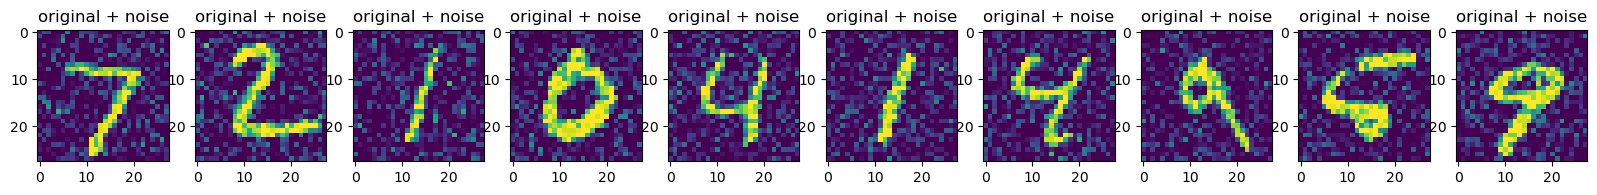

In [7]:
def plot_noisy_images(x_test_noisy):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.title("original + noise")
        plt.imshow(x_test_noisy[i])

    plt.show()

plot_noisy_images(x_test_noisy)

## 2.2 The model
    Implement a convolutional autoencoder (and a variational autoencoder for anoutstanding).

### 2.2.1 Convolutional Autoencoder
    • The Autoencoder should consist of an encoder and a decoder, which can be called independently6.
    • Encoder: The encoder should reduce the size of feature maps like a CNN78. At the end of the encoder, flatten the feature maps and use a dense layer to produce an embedding of a certain size9.
    • Decoder: The decoder takes the embedding from the encoder as input. Use a dense layer to restore the dimensionality of the flattened feature maps from the encoder and reshape the resulting vector into feature maps again. Use upsampling or transposed convolutions to mirror your encoder. As an output layer, use a convolutional layer with one filter and sigmoid activation to produce an output image.

In [7]:
# Create a convolutional autoencoder class
class Denoise(tf.keras.Model):
    def __init__(self):
        super(Denoise, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(28, 28 ,1)),
            tf.keras.layers.Conv2D(
                filters=16, kernel_size=(3, 3), strides=2, activation='relu', 
                padding='same', name='hidden_layer_1'),
            # tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
            tf.keras.layers.Conv2D(
                filters=8, kernel_size=(3, 3), strides=2, activation='relu', 
                padding='same', name='hidden_layer_2'),
            # tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
            # tf.keras.layers.Flatten(), 
            # Latent vector
            # tf.keras.layers.Dense(units=4, activation='relu', name='code_layer')
        ])

        self.decoder = tf.keras.Sequential([
            # tf.keras.layers.Reshape(target_shape=(7,7,32)),
            tf.keras.layers.Conv2DTranspose(
                filters=8, kernel_size=3, strides=2, activation='relu', 
                padding='same', name='hidden_layer_3'),
            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=3, strides=2, activation='relu', 
                padding='same', name='hidden_layer_4'),
            tf.keras.layers.Conv2D(
                filters=1, kernel_size=(3, 3), activation='sigmoid',
                padding='same', name='output_layer')
        ])

    @tf.function
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

### 2.2.2 Outstanding: (Variational Autoencoder)
    For the implementation of a Variational Autoencoder refer to online sources. There are good tutorials that do a better job at explaining the implementation than we can do in a few lines of text here. There are also different ways to implement VAEs in tensorflow. Here is a guide using only tensorflow. There is also the tensorflow probability library, which provides probabilistic layers. Have a look at this tutorial, which explains how to build VAEs with tfp. You can also use any other source that you can dig up. Please explain in detail how sampling and the loss are handled in your implementation so we know you did not just copy and paste without understanding whats going on. If you run into troublesin this part, feel free to come to the Q&A or ask on the forum.

In [8]:
# Create a convolutional variational autoencoder class
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()

        self.latent_dim = latent_dim
        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ])
            
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [9]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

In [10]:
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [11]:
@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# 2.3 Training
    Then train your network(s). If you are referring to online sources here, do not get confused! Normally, autoencoders are unsupervised and do not deal with targets, thus you would compute the loss between the input and the prediction. As we are working with a de-noising example, however, we actually have a target, namely the original image. We thus want to compute the loss between thoriginal image (as target) and the reconstructed image obtained from the noisy input. While training, it is nice to plot some example images from the test set with their reconstructed counterparts to visualize the training progress

In [12]:
def train_conv_autoencoder(autoencoder, x_train, x_test, x_train_noisy_img, x_test_noisy_img):
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    EXPERIMENT_NAME = 'RNN_cumsum'
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f'./logs/{EXPERIMENT_NAME}/{current_time}')

    # Train convolutional autoencoder
    history = autoencoder.fit(x_train_noisy_img,
                                x_train,
                                batch_size=32,
                                epochs=10,
                                shuffle=True,
                                validation_data=(x_test_noisy_img, x_test),
                                callbacks=logging_callback)

    # Save model
    autoencoder.save(filepath='../Homework8/saved_models/')

    visualize_conv_autoencoder_data(history)

In [13]:
def train_CVAE(model, latent_dim):
    epochs = 10
    num_examples_to_generate = 16

    # keeping the random vector constant for generation (prediction) so
    # it will be easier to see the improvement.
    random_vector_for_generation = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    loss = tf.keras.metrics.Mean()

    # Pick a sample of the test set for generating output images
    assert batch_size >= num_examples_to_generate
    for test_batch in test_dataset_cvae.take(1):
        test_sample = test_batch[0:num_examples_to_generate, :, :, :]
    
    generate_and_save_images(model, 0, test_sample)

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset_cvae:
            train_step(model, train_x, optimizer)
        end_time = time.time()

    for test_x in test_dataset_cvae:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

    plt.imshow(display_image(epoch))
    # Display images
    plt.axis('off')  

# 2.4 Latent Space Analysis
    Embed the first 1000 images of the test set using the encoder. Reduce the dimensionality of the embeddings to two using the t-SNE algorithm. Then plot the data points, coloured according to their class. Evaluate the result. Is it what you expected? Further, interpolate linearly between the embeddings of two images and plot the reconstructed images. For the Variational Autoencoder part do the same and compare the results.

In [14]:
def visualize_conv_autoencoder_data(history):
    # Plotting the loss data
    plt.figure(figsize=(12,12))
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel('Categorical Crossentropy loss')

    plt.show()

In [15]:
def plot_result_images(decoded_images, x_test_noisy):
    n = 10
    plt.figure(figsize=(20,4))
    for i in range(n):
        # display original + noise
        ax = plt.subplot(2, n, i+1)
        plt.title("original + noise")
        plt.imshow(x_test_noisy[i])
        plt.get_xaxis().set_visible(False)
        plt.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(2, n, i+n+1)
        plt.title("reconstructed")
        plt.imshow(decoded_images[i])
        plt.get_xaxis().set_visible(False)
        plt.get_yaxis().set_visible(False)

    plt.show()

In [16]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [17]:
# Display a generated image from the last training epoch
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

Epoch 1/10
1875/1875 [==============================] - 38s 16ms/step - loss: 0.1158 - val_loss: 0.1140
Epoch 2/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 7/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 8/10
1875/1875 [==============================] - 48s 25ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 10/10
1875/1875 [==============================] - 47s 25m

INFO:tensorflow:Assets written to: ../Homework8/saved_models/assets


INFO:tensorflow:Assets written to: ../Homework8/saved_models/assets


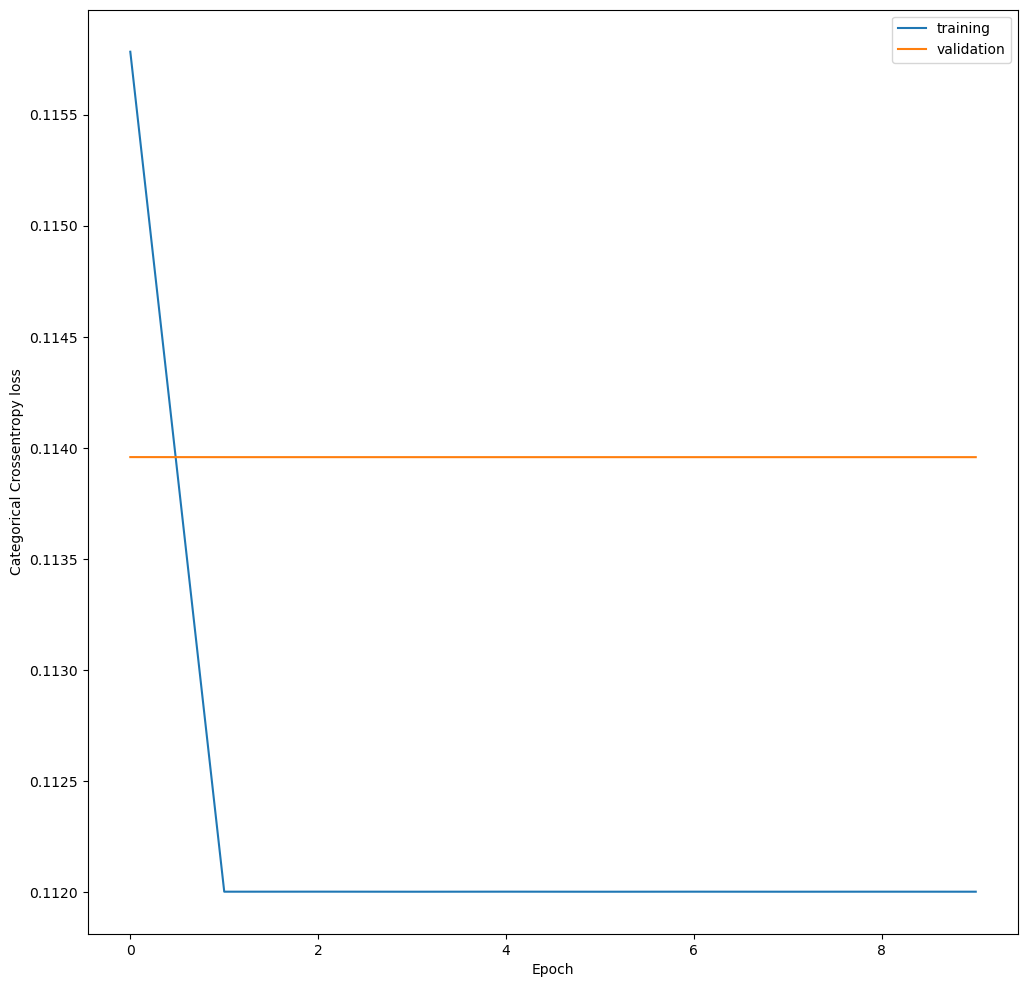

In [18]:
# Define convolutional autoencoder 
conv_autoencoder_model = Denoise()
cvae_model = CVAE(latent_dim)

train_conv_autoencoder(conv_autoencoder_model, x_train, x_test, x_train_noisy, x_test_noisy)

In [19]:
# Let's take a look at a summary of the encoder. 
# Notice how the images are downsampled from 28x28 to 7x7
conv_autoencoder_model.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Conv2D)     (None, 14, 14, 16)        160       
                                                                 
 hidden_layer_2 (Conv2D)     (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [20]:
# The decoder upsamples the images back from 7x7 to 28x28.
conv_autoencoder_model.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_3 (Conv2DTrans  (None, 14, 14, 8)        584       
 pose)                                                           
                                                                 
 hidden_layer_4 (Conv2DTrans  (None, 28, 28, 16)       1168      
 pose)                                                           
                                                                 
 output_layer (Conv2D)       (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Plotting both the noisy images and the denoised images produced by the autoencoder.
encoded_images = conv_autoencoder_model.encoder(x_test_noisy).numpy()
decoded_images = conv_autoencoder_model.decoder(encoded_images).numpy()

plot_result_denoised_images(decoded_images, x_test_noisy)

ResourceExhaustedError: Exception encountered when calling layer "hidden_layer_4" "                 f"(type Conv2DTranspose).

{{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[10000,8,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput]

Call arguments received by layer "hidden_layer_4" "                 f"(type Conv2DTranspose):
  • inputs=tf.Tensor(shape=(10000, 14, 14, 8), dtype=float32)

Epoch: 10, Test set ELBO: -150.05563354492188, time elapse for current epoch: 74.56628727912903


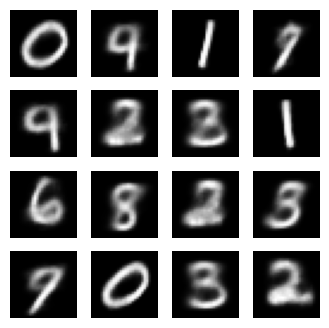

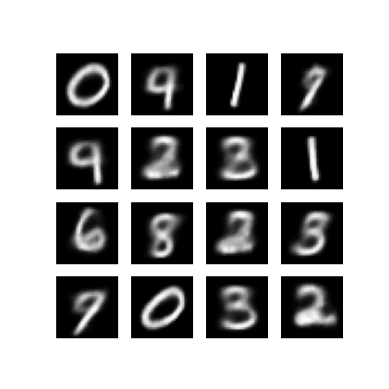

In [22]:
train_CVAE(cvae_model, latent_dim)